# deep RNN 
In notebook 11, we managed to train an RNN with one SimpleRNN layer of 4 neurons.
Here, we will add layers and neurons.

We will hold off on the stratified split by sequence length.
To save RAM and CPU during testing, we will only use short sequences.

We will hold off on trying the word2vec embedding.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')  # save RAM


Load and encode the sequence data.

In [2]:
MIN_SEQ_LEN=200
MAX_SEQ_LEN=25000 ### this screens 4 outliers in the complete dataset
MAX_SEQ_LEN=2000  ### we use this to reduce training RAM and CPU
DEFLINE='>'
ncfile='ncRNA.fasta' 
pcfile='pcRNA.fasta' 
#ncfile='tiny.ncRNA.fasta' # 10 seqs for faster debugging
#pcfile='tiny.pcRNA.fasta' 

# Assume file was preprocessed to contain one line per seq.
# Returned structure is ndarray of ndarray i.e no python lists inside.
def load_fasta(filename):
    seqs=[]
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE and len(line)>=MIN_SEQ_LEN and len(line)<=MAX_SEQ_LEN:
                line=line.rstrip()
                chars=np.array(list(line))
                seqs.append(chars.reshape(-1, 1)) # reshaped changes (any,) to (any,1)
    nparray=np.array(seqs)
    return nparray

print("Load "+ncfile)
nc_seqs = load_fasta(ncfile)
print("Load "+pcfile)
pc_seqs = load_fasta(pcfile)

encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
#seq=tf.reshape(nc_seqs[0],shape=(-1, 1)) # tensor flow version
seq=nc_seqs[0].reshape(-1, 1)
encoder.fit(seq)
print("Encoder categories")
encoder.categories_

print("Ecode the non-coding sequences")
nc_list=[]
for seq in nc_seqs:
    encoded=encoder.transform(seq)  
    nc_list.append(encoded)
    
nc_all=np.array(nc_list) # .reshape(-1,1)
print("shape: "+str(nc_all.shape))
print("element 0 is a sequence: \n"+str(nc_all[0]))
print("element 0,0 is one letter: "+str(nc_all[0][0]))

print("Encode the protein-coding sequences")
pc_list=[]
for seq in pc_seqs:
    encoded=encoder.transform(seq)
    pc_list.append(encoded)

pc_all=np.array(pc_list) # .reshape(-1,1)
pc_all.shape

Load ncRNA.fasta
Load pcRNA.fasta
Encoder categories
Ecode the non-coding sequences
shape: (15173,)
element 0 is a sequence: 
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
element 0,0 is one letter: [0. 0. 0. 1.]
Encode the protein-coding sequences


(13126,)

Create train and validation sets.

In [3]:
nc_labels=np.zeros(shape=(17711))
pc_labels=np.ones(shape=(20152))
#nc_labels=np.zeros(shape=(10))  # fast debugging
#pc_labels=np.ones(shape=(10))

#nc_labeled=np.concatenate((nc_all,nc_labels),axis=1)
#pc_labeled=np.concatenate((pc_all,pc_labels),axis=1)
all_seqs=np.concatenate((nc_all,pc_all),axis=0)
all_labels=np.concatenate((nc_labels,pc_labels),axis=0)

print("shape of sequences, shape of labels")
all_seqs.shape,all_labels.shape

splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(all_seqs):
    train_seqs =   all_seqs[train_index]
    train_labels = all_labels[train_index]
    test_seqs =    all_seqs[test_index]
    test_labels =  all_labels[test_index]
 
print("shape of train")
print(train_seqs.shape,train_labels.shape)
print("shape of test")
print(test_seqs.shape,test_labels.shape)

print("Convert numpy array to python 3D array")
def numpy_to_python_3D(np_seqs):
    one_set = []
    tlen = len(np_seqs)
    for i in range(tlen): # for every sequence in set
        one_seq = []
        slen = len(np_seqs[i])
        for j in range(slen): # for ever letter in sequence
            one_letter=np_seqs[i][j]
            one_seq.append(one_letter)
        one_set.append(one_seq)
    return one_set
train_seqs = numpy_to_python_3D(train_seqs)
test_seqs = numpy_to_python_3D(test_seqs)
train_labels = train_labels.tolist()
test_labels = test_labels.tolist()

# Now that values are shuffled, partition gives random sample.
data_size=len(train_seqs)
PARTITION=int(data_size*0.8)
print("Partition = "+str(PARTITION))

print("Partition train/validation")
X_train=train_seqs[:PARTITION]
X_valid=train_seqs[PARTITION:]
y_train=train_labels[:PARTITION]
y_valid=train_labels[PARTITION:]
print("Lengths of train,valid")
print((len(X_train),len(X_valid)))

# Free memory for the next step
nc_seqs=None
pc_seqs=None
all_seqs=None
nc_labels=None
pc_labels=None
train_seqs=None
train_labels=None

print("Convert to tensors")
X_train = tf.ragged.constant(X_train)  # This takes a long time and hogs memory
print(type(X_train))
print(X_train.shape)
y_train = tf.convert_to_tensor(y_train)
print(type(y_train))
print(y_train.shape)
X_valid = tf.ragged.constant(X_valid)
print(type(X_valid))
print(X_valid.shape)
y_valid = tf.convert_to_tensor(y_valid)
print(type(y_valid))
print(y_valid.shape)

shape of sequences, shape of labels
shape of train
(22639,) (22639,)
shape of test
(5660,) (5660,)
Convert numpy array to python 3D array
Partition = 18111
Partition train/validation
Lengths of train,valid
(18111, 4528)
Convert to tensors
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(18111, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(18111,)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(4528, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(4528,)


In [4]:
print("Build the model")
seq_len=None  # none indicates variable length
input_features=4  # one hot encoding of DNA means 4 categories
rnn2 = keras.models.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, input_shape=[seq_len,input_features]),
    keras.layers.SimpleRNN(16, return_sequences=True),
    keras.layers.SimpleRNN(16, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

print("Build the training environment")
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
rnn2.summary()

Build the model
Build the training environment
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 16)          336       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 16)          528       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 16)          528       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 18        
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________


In [5]:
print("Train the model")
history = rnn2.fit(X_train,y_train,epochs=1,validation_data=(X_valid,y_valid))


Train the model
566/566 [==============================] - 1105s 2s/step - loss: 0.8660 - accuracy: 0.5626 - val_loss: 0.6517 - val_accuracy: 0.6290


In [7]:
print("Continue training the model")
history = rnn2.fit(X_train,y_train,epochs=4,validation_data=(X_valid,y_valid))

Continue training the model
Epoch 1/4
566/566 [==============================] - 1397s 2s/step - loss: 0.6600 - accuracy: 0.6180 - val_loss: 0.6591 - val_accuracy: 0.6327
Epoch 2/4
566/566 [==============================] - 4242s 7s/step - loss: 0.6579 - accuracy: 0.6254 - val_loss: 0.6533 - val_accuracy: 0.6341
Epoch 3/4
566/566 [==============================] - 1084s 2s/step - loss: 0.6547 - accuracy: 0.6255 - val_loss: 0.6528 - val_accuracy: 0.6327
Epoch 4/4
566/566 [==============================] - 1072s 2s/step - loss: 0.6548 - accuracy: 0.6267 - val_loss: 0.6508 - val_accuracy: 0.6283


Visualize training history.


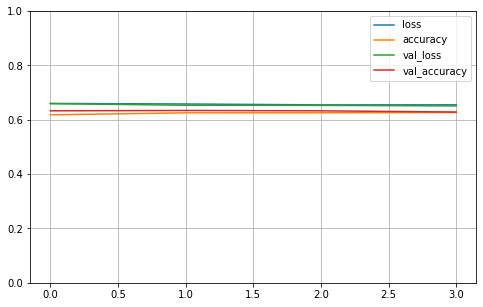

In [8]:
print("Visualize training history.")
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Resources.
[Working with RNNs](https://keras.io/guides/working_with_rnns/).
[Recurrent Neural Networks with Keras](https://www.tensorflow.org/guide/keras/rnn#rnns_with_listdict_inputs_or_nested_inputs).
Function tf.convert_to_tensor [docs](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor).
Function tf.reshape [docs](https://www.tensorflow.org/api_docs/python/tf/reshape).
Ragged Tensors [tutorial](https://www.tensorflow.org/guide/tensor#ragged_tensors)
and [docs](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor#documenting_raggedtensor_shapes_2) and [module](https://www.tensorflow.org/api_docs/python/tf/ragged).
Incredible speedup for convert to tensor by sirfz on [stackoverflow](https://stackoverflow.com/questions/44353509/tensorflow-tf-constant-initializer-is-very-slow).


